In [1]:
from google.colab import files
uploaded = files.upload()  # Pick your Shakespeare_data.csv file



Saving Shakespeare_data.csv to Shakespeare_data.csv


In [2]:
import pandas as pd
df = pd.read_csv("Shakespeare_data.csv")
df.head()


,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Parameters
sequence_length = 100
embedding_dim = 128
hidden_size = 256
num_layers = 2
dropout_rate = 0.2
learning_rate = 0.003
batch_size = 64
num_epochs = 20
use_lstm = True


In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_len):
        chars = sorted(set(text))
        self.char2idx = {ch: idx for idx, ch in enumerate(chars)}
        self.idx2char = {idx: ch for ch, idx in self.char2idx.items()}
        self.vocab_size = len(chars)
        self.data = torch.tensor([self.char2idx[c] for c in text], dtype=torch.long)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_len]
        target = self.data[idx + 1:idx + self.seq_len + 1]
        return torch.tensor(seq), torch.tensor(target)


In [5]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_layers, dropout, use_lstm=True):
        super(CharRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        if use_lstm:
            self.rnn = nn.LSTM(emb_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:
            self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh',
                              dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden


In [6]:
def train_model(model, dataloader, criterion, optimizer, vocab_size, device):
    model.train()
    all_loss = []
    for epoch in range(num_epochs):
        total_loss = 0
        for seq, target in dataloader:
            seq, target = seq.to(device), target.to(device)
            optimizer.zero_grad()
            output, _ = model(seq)
            loss = criterion(output.view(-1, vocab_size), target.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        all_loss.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    return all_loss

def generate_text(model, start_str, char2idx, idx2char, length=300):
    model.eval()
    input_seq = torch.tensor([char2idx[c] for c in start_str]).unsqueeze(0).to(next(model.parameters()).device)
    generated = start_str
    hidden = None
    for _ in range(length):
        with torch.no_grad():
            output, hidden = model(input_seq, hidden)
        last_char_logits = output[:, -1, :]
        predicted_idx = torch.argmax(last_char_logits, dim=-1).item()
        generated += idx2char[predicted_idx]
        input_seq = torch.tensor([[predicted_idx]]).to(next(model.parameters()).device)
    return generated


In [7]:
text = " ".join(df["PlayerLine"].dropna().tolist())  # Combine all dialogue lines
text = text[:100000]  # Truncate text to first 100,000 characters

dataset = CharDataset(text, sequence_length)  # Create dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # Create dataloader

# Initialize model
model = CharRNN(dataset.vocab_size, embedding_dim, hidden_size, num_layers, dropout_rate, use_lstm=use_lstm)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
loss_list = train_model(model, dataloader, criterion, optimizer, dataset.vocab_size, device)


<ipython-input-4-4a7ce9223e9a>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(seq), torch.tensor(target)


Epoch [1/20], Loss: 1.2810
Epoch [2/20], Loss: 0.5810
Epoch [3/20], Loss: 0.4098
Epoch [4/20], Loss: 0.3527
Epoch [5/20], Loss: 0.3253
Epoch [6/20], Loss: 0.3078
Epoch [7/20], Loss: 0.2968
Epoch [8/20], Loss: 0.2877
Epoch [9/20], Loss: 0.2807
Epoch [10/20], Loss: 0.2748
Epoch [11/20], Loss: 0.2699
Epoch [12/20], Loss: 0.2657
Epoch [13/20], Loss: 0.2616
Epoch [14/20], Loss: 0.2588
Epoch [15/20], Loss: 0.2565
Epoch [16/20], Loss: 0.2535
Epoch [17/20], Loss: 0.2519
Epoch [18/20], Loss: 0.2486
Epoch [19/20], Loss: 0.2474
Epoch [20/20], Loss: 0.2449


In [8]:
 print(len(dataset))  # This will show how many samples __getitem__ is handling

99900


In [9]:
def generate_text(model, start_text, char2idx, idx2char, length, device, temperature=1.0):
    model.eval()
    input_seq = torch.tensor([char2idx[c] for c in start_text], dtype=torch.long).unsqueeze(0).to(device)
    hidden = None

    generated = list(start_text)

    for _ in range(length):
        output, hidden = model(input_seq, hidden)
        output = output[:, -1, :] / temperature
        probs = torch.nn.functional.softmax(output, dim=-1).squeeze()
        next_char_idx = torch.multinomial(probs, num_samples=1).item()
        next_char = idx2char[next_char_idx]

        generated.append(next_char)
        input_seq = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)

    return ''.join(generated)


In [12]:

user_input = input("Enter the starting text: ")

# Generate text after training
sample = generate_text(
    model,
    start_text=user_input,
    char2idx=dataset.char2idx,
    idx2char=dataset.idx2char,
    length=200,
    device=device,
    temperature=0.8
)

print("\nGenerated Text:\n")
print(sample)


Enter the starting text: hiiiiii

Generated Text:

hiiiiiins' wime me out to me? Marry, my lord, there is a nobleman of the court at door would speak with you: he says he comes from your father. Give him as much as will make him a royal man, and send him bac


<ipython-input-4-4a7ce9223e9a>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(seq), torch.tensor(target)


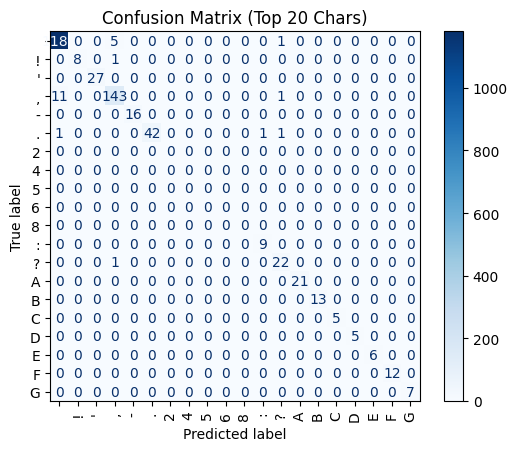

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Run one batch and get predictions
seq, target = next(iter(dataloader))
seq, target = seq.to(device), target.to(device)

model.eval()
with torch.no_grad():
    output, _ = model(seq)
    preds = output.argmax(dim=-1)

# Flatten for confusion matrix
y_true = target.view(-1).cpu().numpy()
y_pred = preds.view(-1).cpu().numpy()

# Limit to top N characters for clarity
N = 20  # top 20 most common characters
chars = [dataset.idx2char[i] for i in range(dataset.vocab_size)]
conf_mat = confusion_matrix(y_true, y_pred, labels=range(dataset.vocab_size))
disp = ConfusionMatrixDisplay(conf_mat[:N, :N], display_labels=chars[:N])
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix (Top 20 Chars)")
plt.show()


In [14]:
correct = (y_true == y_pred).sum()
total = len(y_true)
accuracy = correct / total
print(f"Character-level Accuracy on Sample Batch: {accuracy:.4f}")


Character-level Accuracy on Sample Batch: 0.9580


In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Reference is from the actual text
reference = list(text[100:300])
generated = list(sample)

# Use smoothing to avoid zero BLEU for short text
smoothie = SmoothingFunction().method4
bleu = sentence_bleu([reference], generated, weights=(0.5, 0.5), smoothing_function=smoothie)
print(f"BLEU Score: {bleu:.4f}")


BLEU Score: 0.5632


In [16]:
from torch.utils.data import random_split

# 90% train, 10% validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, vocab_size, device):
    train_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for seq, target in train_loader:
            seq, target = seq.to(device), target.to(device)
            optimizer.zero_grad()
            output, _ = model(seq)
            loss = criterion(output.view(-1, vocab_size), target.view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for seq, target in val_loader:
                seq, target = seq.to(device), target.to(device)
                output, _ = model(seq)
                val_loss = criterion(output.view(-1, vocab_size), target.view(-1))
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_loss_list, val_loss_list


<ipython-input-4-4a7ce9223e9a>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(seq), torch.tensor(target)


Epoch [1/20] - Train Loss: 0.2437, Val Loss: 0.1498
Epoch [2/20] - Train Loss: 0.2426, Val Loss: 0.1504
Epoch [3/20] - Train Loss: 0.2411, Val Loss: 0.1504
Epoch [4/20] - Train Loss: 0.2395, Val Loss: 0.1503
Epoch [5/20] - Train Loss: 0.2382, Val Loss: 0.1499
Epoch [6/20] - Train Loss: 0.2378, Val Loss: 0.1509
Epoch [7/20] - Train Loss: 0.2364, Val Loss: 0.1503
Epoch [8/20] - Train Loss: 0.2353, Val Loss: 0.1507
Epoch [9/20] - Train Loss: 0.2348, Val Loss: 0.1499
Epoch [10/20] - Train Loss: 0.2338, Val Loss: 0.1489
Epoch [11/20] - Train Loss: 0.2333, Val Loss: 0.1488
Epoch [12/20] - Train Loss: 0.2322, Val Loss: 0.1495
Epoch [13/20] - Train Loss: 0.2313, Val Loss: 0.1503
Epoch [14/20] - Train Loss: 0.2311, Val Loss: 0.1498
Epoch [15/20] - Train Loss: 0.2298, Val Loss: 0.1498
Epoch [16/20] - Train Loss: 0.2291, Val Loss: 0.1494
Epoch [17/20] - Train Loss: 0.2288, Val Loss: 0.1494
Epoch [18/20] - Train Loss: 0.2280, Val Loss: 0.1503
Epoch [19/20] - Train Loss: 0.2272, Val Loss: 0.1503
Ep

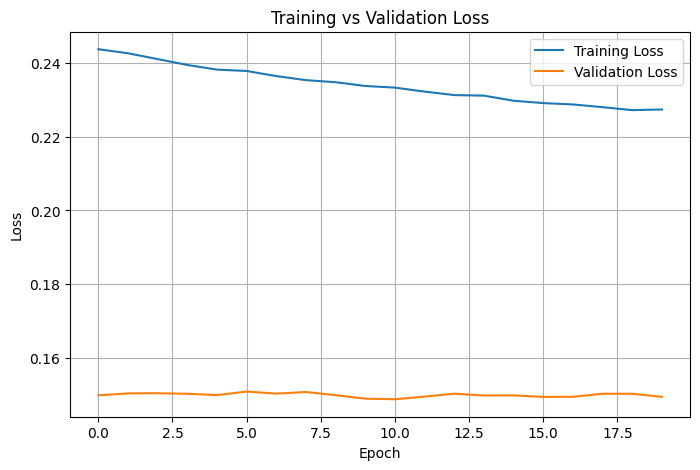

In [18]:
train_loss_list, val_loss_list = train_model(model, train_loader, val_loader, criterion, optimizer, dataset.vocab_size, device)

# Plot both
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
